In [1]:
import geopandas
import geopandas as gpd
import pandas as pd
import numpy as np
import pyrosm
import osmnx as ox
import momepy
import pygeos
import libpysal
import scipy
import glob
import networkx as nx
from tqdm import tqdm
import rioxarray
import xarray
import rasterstats
from download import download
import cenpy
import contextily

import dask_geopandas
from dask.distributed import Client, LocalCluster, as_completed
import utils.momepy

from utils.momepy_utils import (
    _circle_radius,
    centroid_corner,
    elongation,
    get_corners,
    get_edge_ratios,
    get_nodes,
    solar_orientation_poly,
    squareness,
)

import utils.consolidate
from time import time

In [2]:
import warnings

warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')

## Microsoft building footprints

For Houston, we will use [Microsoft building footprints](https://www.microsoft.com/en-us/maps/building-footprints), which means we have to download Texas and extract Houston FUA.

In [4]:
download("https://usbuildingdata.blob.core.windows.net/usbuildings-v1-1/Texas.zip", '../../urbangrammar_samba/sp_sig_concept/houston/texas_footprint', kind='zip')

Creating data folder...

file_sizes: 100%|████████████████████████████| 341M/341M [00:54<00:00, 6.23MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/texas_footprint


'../../urbangrammar_samba/sp_sig_concept/houston/texas_footprint'

In [6]:
fua = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/ghs_fua_2015/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg")
fua_4326 = fua.to_crs(4326)
fua_4326.geometry = fua_4326.buffer(0)  # fix geometry topology

polygon = fua_4326[fua_4326.eFUA_name == 'Houston'].geometry.iloc[0]

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [8]:
buildings = gpd.read_file("../../urbangrammar_samba/sp_sig_concept/houston/texas_footprint/Texas.geojson", mask=polygon)

In [10]:
buildings.is_valid.all()

False

In [11]:
buildings.geometry = buildings.buffer(0)

In [12]:
buildings.is_valid.all()

True

In [13]:
buildings['uID'] = range(len(buildings))

In [14]:
buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/buildings.pq")

## OSM roads

In [15]:
type_filter = '["highway"~"living_street|motorway|motorway_link|pedestrian|primary|primary_link|residential|secondary|secondary_link|service|tertiary|tertiary_link|trunk|trunk_link"]'

streets_graph = ox.graph_from_polygon(polygon, network_type='all_private', custom_filter=type_filter, retain_all=True)
streets_graph = ox.projection.project_graph(streets_graph)
gdf = ox.graph_to_gdfs(ox.get_undirected(streets_graph), nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
gdf.highway = gdf.highway.astype(str)
path = f'../../urbangrammar_samba/sp_sig_concept/houston/roads_osm.pq'
gdf[['highway', 'geometry']].to_parquet(path)

In [16]:
tags = {'natural': ['water', 'coastline', 'spring']}
gdf = ox.geometries_from_polygon(polygon, tags)
path = f'../../urbangrammar_samba/sp_sig_concept/houston/water_osm.pq'
gdf[['natural', 'geometry']].to_parquet(path)

<ipython-input-16-4160ee8a8b9f>:4: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf[['natural', 'geometry']].to_parquet(path)


In [17]:
tags = {'railway': True}
gdf = ox.geometries_from_polygon(polygon, tags)
gdf = gdf[gdf.geom_type == 'LineString']
gdf = gdf[gdf.tunnel != 'yes']
path = f'../../urbangrammar_samba/sp_sig_concept/houston/railway_osm.pq'
gdf[['railway', 'geometry']].to_parquet(path)

/opt/conda/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-17-b18adb2aa352>:6: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  gdf[['railway', 'geometry']].to_parquet(path)


## preprocessing

In [18]:
buildings.geom_type.value_counts()

Polygon         1874421
MultiPolygon          9
dtype: int64

In [19]:
buildings = buildings.explode().reset_index(drop=True)

In [20]:
buildings = buildings.to_crs(3081)

In [21]:
buildings.is_valid.all()

True

In [23]:
buildings['uID'] = range(len(buildings))

In [24]:
buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/buildings.pq")

<ipython-input-24-a1beffc3da3b>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  buildings.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/buildings.pq")


In [3]:
railway = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/houston/railway_osm.pq').to_crs(buildings.crs)

NameError: name 'buildings' is not defined

In [26]:
railway.geom_type.unique()

array(['LineString'], dtype=object)

In [27]:
roads = gpd.read_parquet('../../urbangrammar_samba/sp_sig_concept/houston/roads_osm.pq').to_crs(buildings.crs)

<AxesSubplot:>

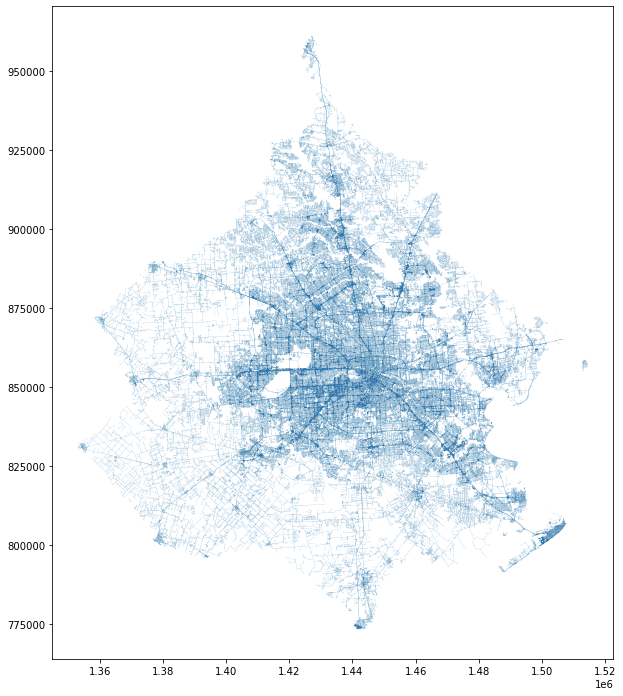

In [28]:
roads.plot(figsize=(12, 12), linewidth=.1)

In [34]:
%time extended_railway = utils.momepy.extend_lines(railway, 30, target=roads, extension=.1)

CPU times: user 3.07 s, sys: 16 ms, total: 3.09 s
Wall time: 3.08 s


In [35]:
water = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/water_osm.pq").to_crs(buildings.crs)

In [36]:
water.geom_type.value_counts()

Polygon         5210
LineString       242
MultiPolygon       9
Point              2
dtype: int64

In [37]:
water = water[~(water.geom_type == "Point")].explode()
water.loc[water.geom_type == "Polygon", "geometry"] = water.loc[water.geom_type == "Polygon", "geometry"].boundary

In [42]:
limit = fua_4326[fua_4326.eFUA_name == 'Houston'].to_crs(buildings.crs).geometry.iloc[[0]]

In [43]:
%%time
enclosures = utils.momepy.enclosures(roads, limit=limit, additional_barriers=[extended_railway, water])

CPU times: user 2min 30s, sys: 68 ms, total: 2min 30s
Wall time: 2min 30s


<AxesSubplot:>

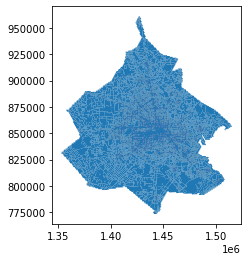

In [44]:
enclosures.plot()

In [45]:
enclosures.is_valid.all()

True

In [46]:
enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")

<ipython-input-46-cbbf668f7ec1>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  enclosures.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")


In [3]:
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/buildings.pq")

In [3]:
client = Client(LocalCluster(n_workers=16))
client

Client Scheduler: tcp://127.0.0.1:40391 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [5]:
%%time
tess = utils.momepy.Tessellation(buildings, 'uID', enclosures=enclosures, n_chunks=16)

/opt/conda/lib/python3.8/site-packages/distributed/worker.py:3373: UserWarning: Large object of size 338.34 MB detected in task graph: 
  ([           eID                                   ...  0.05, 'uID'],)
Consider scattering large objects ahead of time
with client.scatter to reduce scheduler burden and 
keep data on workers

    future = client.submit(func, big_data)    # bad

    big_future = client.scatter(big_data)     # good
    future = client.submit(func, big_future)  # good
  warnings.warn(


CPU times: user 11min 56s, sys: 1min 9s, total: 13min 6s
Wall time: 2h 5min 27s


In [ ]:
tessellation = tess.tessellation
tessellation['tID'] = range(len(tessellation))
tessellation.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/tessellation.pq")

In [4]:
# !pip install git+git://github.com/geopandas/geopandas.git
# !pip install git+git://github.com/jsignell/dask-geopandas.git
# !pip install git+git://github.com/martinfleis/momepy.git

## Primary morphometric characters

In [4]:
tess = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/tessellation.pq")
enclosures = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")
buildings = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/buildings.pq")

In [5]:
tess = tess.rename_geometry("tessellation").merge(buildings[['uID', 'geometry']].rename_geometry("buildings"), on='uID', how='left')

In [6]:
tess.head(5)

,uID,tessellation,eID,tID,buildings
0,114604.0,"POLYGON ((1444405.065 789808.767, 1444407.122 ...",0,0,"POLYGON ((1444429.613 789804.887, 1444430.130 ..."
1,601963.0,"POLYGON ((1444529.267 789801.698, 1444529.292 ...",0,1,"POLYGON ((1444526.829 789799.830, 1444514.312 ..."
2,656147.0,"POLYGON ((1444435.839 789772.425, 1444435.372 ...",0,2,"POLYGON ((1444456.635 789818.966, 1444457.869 ..."
3,692179.0,"POLYGON ((1444416.947 789806.634, 1444416.627 ...",0,3,"POLYGON ((1444416.132 789808.871, 1444415.876 ..."
4,782446.0,"POLYGON ((1444480.706 789774.447, 1444480.824 ...",0,4,"POLYGON ((1444485.052 789794.666, 1444484.310 ..."


In [7]:
tess.shape

(2043581, 5)

In [8]:
ddf = dask_geopandas.from_geopandas(tess, npartitions=16)

In [9]:
%%time
## Measure morphometric characters
# Building area
ddf['sdbAre'] = ddf.buildings.area

# Building perimeter
ddf['sdbPer'] = ddf.buildings.length

# Courtyard area
exterior_area = ddf.buildings.map_partitions(lambda series: pygeos.area(pygeos.polygons(series.exterior.values.data)), meta='float')
ddf['sdbCoA'] = exterior_area - ddf['sdbAre']

# Circular compactness
hull = ddf.buildings.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
ddf['ssbCCo'] = ddf['sdbAre'] / (np.pi * radius ** 2)

# Corners
ddf['ssbCor'] = ddf.buildings.apply(lambda g: get_corners(g), meta='float')

# Squareness
ddf['ssbSqu'] = ddf.buildings.apply(lambda g: squareness(g), meta='float')

# Equivalent rectangular index
bbox = ddf.buildings.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
ddf['ssbERI'] = (ddf['sdbAre'] / bbox.area).pow(1./2) * (bbox.length / ddf['sdbPer'])

# Elongation
ddf['ssbElo'] = bbox.map_partitions(lambda s: elongation(s), meta='float')

# Centroid corner mean distance and deviation
def _centroid_corner(series):
    ccd = series.apply(lambda g: centroid_corner(g))
    return pd.DataFrame(ccd.to_list(), index=series.index)


ddf[['ssbCCM', 'ssbCCD']] = ddf.buildings.map_partitions(_centroid_corner, meta=pd.DataFrame({0: [0.1], 1: [1.1]}))

# Solar orientation
ddf['stbOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Tessellation longest axis length
hull = ddf.tessellation.convex_hull.exterior

ddf['sdcLAL'] = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2

# Tessellation area
ddf['sdcAre'] = ddf.tessellation.area

# Circular compactness
radius = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float')
ddf['sscCCo'] = ddf['sdcAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = ddf.tessellation.apply(lambda g: g.minimum_rotated_rectangle, meta=geopandas.GeoSeries())
ddf['sscERI'] = (ddf['sdcAre'] / bbox.area).pow(1./2) * (bbox.length / ddf.tessellation.length)

# Solar orientation
ddf['stcOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Covered area ratio
ddf['sicCAR'] = ddf['sdbAre'] / ddf['sdcAre']

# Building-cell alignment
ddf['stbCeA'] = (ddf['stbOri'] - ddf['stcOri']).abs()

# Compute all characters using dask
df = ddf.compute()

/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:54: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  return geopandas.GeoDataFrame(df, crs=x.crs)
/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:54: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  return geopandas.GeoDataFrame(df, crs=x.crs)
/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:54: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  return geopandas.GeoDataFrame(df, crs=x.crs)
/opt/conda/lib/python3.8/site-packages/dask_geopandas/backends.py:54: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  return geopandas.GeoDataFrame(df, crs=x.crs)
/opt

CPU times: user 2min 10s, sys: 26.2 s, total: 2min 36s
Wall time: 14min 13s


In [10]:
df.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/tess.pq")

In [11]:
%%time
# Load data
encl = dask_geopandas.from_geopandas(enclosures, npartitions=16)

# Area
encl['ldeAre'] = encl.geometry.area

# Perimeter
encl['ldePer'] = encl.geometry.length

# Circular compacntess
hull = encl.geometry.convex_hull.exterior

radius = hull.apply(lambda g: _circle_radius(list(g.coords)) if g is not None else None, meta='float')
encl['lseCCo'] = encl['ldeAre'] / (np.pi * radius ** 2)

# Equivalent rectangular index
bbox = encl.geometry.apply(lambda g: g.minimum_rotated_rectangle if g is not None else None, meta=geopandas.GeoSeries())
encl['lseERI'] = (encl['ldeAre'] / bbox.area).pow(1./2) * (bbox.length / encl['ldePer'])

# Compactness-weighted axis
longest_axis = hull.apply(lambda g: _circle_radius(list(g.coords)), meta='float') * 2
encl['lseCWA'] = longest_axis * ((4 / np.pi) - (16 * encl['ldeAre']) / ((encl['ldePer']) ** 2))

# Solar orientation
encl['lteOri'] = bbox.apply(lambda g: solar_orientation_poly(g), meta='float')

# Compute data and return geopandas.GeoDataFrame
encl_df = encl.compute()

# Weighted number of neighbors
inp, res = encl_df.sindex.query_bulk(encl_df.geometry, predicate='intersects')
indices, counts = np.unique(inp, return_counts=True)
encl_df['neighbors'] = counts - 1
encl_df['lteWNB'] = encl_df['neighbors'] / encl_df['ldePer']

# Measure weighted cells within enclosure
encl_counts = tess.groupby('eID').count()
merged = encl_df[['eID', 'ldeAre']].merge(encl_counts[['tessellation']], how='left', on='eID')
encl_df['lieWCe'] = merged['tessellation'] / merged['ldeAre']

CPU times: user 40.2 s, sys: 1.02 s, total: 41.2 s
Wall time: 52.3 s


In [12]:
# Save data to parquet
encl_df.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")

## chunk data to parts

In [3]:
cells = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/tess.pq")

In [6]:
bounds = cells.total_bounds

In [8]:
bounds[2] - bounds[0]

162386.5983321052

In [53]:
size = 7
grid = gpd.points_from_xy(
    np.repeat(np.linspace(bounds[0], bounds[2], size), size), np.tile(np.linspace(bounds[1], bounds[3], size), size)
)

In [54]:
grid, _ = libpysal.cg.voronoi_frames(np.stack([np.repeat(np.linspace(bounds[0], bounds[2], size), size), np.tile(np.linspace(bounds[1], bounds[3], size), size)]).T, clip="bbox")

<AxesSubplot:>

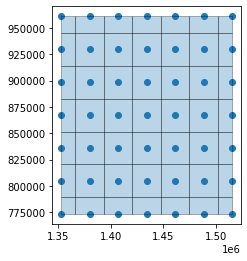

In [55]:
ax = _.plot()
grid.plot(ax=ax, edgecolor="k", alpha=.3)

In [56]:
grid['chunkid'] = range(len(grid))

In [57]:
%time join = gpd.sjoin(gpd.GeoDataFrame(geometry=cells.tessellation.centroid), grid, how='left')

<timed exec>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:3081
Right CRS: None



CPU times: user 13.9 s, sys: 28 ms, total: 14 s
Wall time: 14 s


In [58]:
join.chunkid.value_counts()

24    351064
23    292244
30    271223
31    198118
25    167267
17    157734
16    143206
32     73410
37     64380
38     57297
36     50320
26     39238
18     35988
29     30106
10     13864
43     13712
21     12872
22     11537
9      11384
15      9495
19      8117
8       7634
11      6623
33      5426
27      4870
3       2719
2       2121
45      1252
39       312
28        44
1          4
Name: chunkid, dtype: int64

In [59]:
grid.to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/chunks.pq")

In [60]:
for i in join.chunkid.unique():
    cells[join["chunkid"] == i].to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{i}.pq")

In [67]:
w = libpysal.weights.fuzzy_contiguity(grid)

In [68]:
grid = grid.set_index("chunkid")

In [63]:
total = len(glob.glob("../../urbangrammar_samba/sp_sig_concept/houston/chunked/*"))
total

31

In [72]:
include = pd.Series(index=pd.MultiIndex.from_tuples([], names=['chunk', 'neighbors']), dtype=object)

for ch in tqdm(join.chunkid.unique(), total=total):
    target = grid.loc[ch, 'geometry']

    for n in w.neighbors[ch]:
        try:
            tess = gpd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{int(n)}.pq")

            ind = tess.sindex.query(target, predicate='intersects')

            if ind.size > 0:
                incl = ind.tolist()
                for _ in range(12):
                    inp, res = tess.sindex.query_bulk(tess.geometry.iloc[incl], predicate='intersects')
                    incl += np.unique(res).tolist()
            else:
                incl = []
            include.loc[ch, int(n)] = np.unique(incl)
        except:
            pass

100%|██████████| 31/31 [29:59<00:00, 58.05s/it] 


In [73]:
include = include[include.apply(lambda x: len(x) > 0)]

In [74]:
include

chunk  neighbors
22     21           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
       29           [445, 448, 451, 452, 463, 472, 485, 502, 507, ...
       15           [3, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 43...
       30           [409, 418, 471, 476, 478, 481, 483, 491, 496, ...
       23           [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
                                          ...                        
2      9            [1404, 1408, 1413, 1631, 1632, 1633, 1634, 163...
28     21           [225, 273, 274, 275, 276, 277, 279, 282, 283, ...
       22           [1428, 1429, 1430, 1431, 1432, 1433, 1434, 143...
       29           [3189, 3190, 3191, 3192, 3193, 3194, 3196, 319...
1      8            [1633, 1634, 1635, 1636, 1637, 1638, 1639, 164...
Length: 110, dtype: object

In [75]:
pd.DataFrame(include, columns=['indices']).to_parquet('../../urbangrammar_samba/sp_sig_concept/houston/cross-chunk_indices.pq')

## Generate spatial weights (W)¶

In [2]:
workers = 16
client = Client(LocalCluster(n_workers=8, threads_per_worker=2))
client

Client Scheduler: tcp://127.0.0.1:34487 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 134.91 GB


In [4]:
warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
warnings.filterwarnings('ignore', message='.*Assigning CRS to a GeoDataFrame without a geometry*')

In [5]:
cross_chunk = pd.read_parquet('../../urbangrammar_samba/sp_sig_concept/houston/cross-chunk_indices.pq')
chunks = geopandas.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/chunks.pq")

In [5]:
def generate_w(chunk_id):
    # load cells of a chunk
    try:
        cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")

        # add neighbouring cells from other chunks
        cross_chunk_cells = []

        for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
            add_cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk}.pq").iloc[inds]
            cross_chunk_cells.append(add_cells)

        df = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)

        w = libpysal.weights.Queen.from_dataframe(df, geom_col='tessellation')
        w3 = momepy.sw_high(k=3, weights=w)

        scipy.sparse.save_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w_{chunk_id}.npz", w.sparse)
        scipy.sparse.save_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w3_{chunk_id}.npz", w3.sparse)

        return f"Chunk {chunk_id} processed sucessfully."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

In [8]:
%%time
inputs = iter(range(49))
futures = [client.submit(generate_w, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(generate_w, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 0 does not exist. Skipped.
Chunk 1 processed sucessfully.
Chunk 4 does not exist. Skipped.
Chunk 5 does not exist. Skipped.
Chunk 6 does not exist. Skipped.
Chunk 7 does not exist. Skipped.
Chunk 12 does not exist. Skipped.
Chunk 13 does not exist. Skipped.
Chunk 14 does not exist. Skipped.
Chunk 20 does not exist. Skipped.
Chunk 2 processed sucessfully.
Chunk 3 processed sucessfully.
Chunk 21 processed sucessfully.
Chunk 8 processed sucessfully.
Chunk 19 processed sucessfully.
Chunk 28 processed sucessfully.
Chunk 11 processed sucessfully.
Chunk 15 processed sucessfully.
Chunk 10 processed sucessfully.
Chunk 34 does not exist. Skipped.
Chunk 35 does not exist. Skipped.
Chunk 27 processed sucessfully.
Chunk 33 processed sucessfully.
Chunk 9 processed sucessfully.
Chunk 39 processed sucessfully.
Chunk 40 does not exist. Skipped.
Chunk 41 does not exist. Skipped.
Chunk 42 does not exist. Skipped.
Chunk 18 processed sucessfully.
Chunk 44 does not exist. Skipped.
Chunk 43 processed s

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 37 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 32 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


KilledWorker: ('generate_w-2b6d5a85c393e8ba2e3e7d73bcbabbbe', <Worker 'tcp://127.0.0.1:37659', name: 7, memory: 0, processing: 2>)

distributed.nanny - WARNING - Restarting worker


In [3]:
real_chunks = [int(i[-5:-3].replace("_", "")) for i in glob.glob("../../urbangrammar_samba/sp_sig_concept/houston/chunked/*")]

In [7]:
done = [int(i[-6:-4].replace("_", "")) for i in glob.glob("../../urbangrammar_samba/sp_sig_concept/houston/weights/w3_*")]
missing = [i for i in real_chunks if i not in done]

In [8]:
missing

[24, 30, 23]

In [9]:
workers = 3
client = Client(LocalCluster(n_workers=3, threads_per_worker=1))
client

Client Scheduler: tcp://127.0.0.1:43007 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 3 Cores: 3 Memory: 134.91 GB


In [10]:
inputs = iter([16])
futures = [client.submit(generate_w, next(inputs)) for i in range(3)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(generate_w, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 30 processed sucessfully.
Chunk 23 processed sucessfully.
Chunk 24 processed sucessfully.


In [14]:
cross_chunk

indices
chunk neighbors                                                   
22    21         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
      29         [445, 448, 451, 452, 463, 472, 485, 502, 507, ...
      15         [3, 18, 19, 20, 21, 22, 23, 24, 28, 29, 30, 43...
      30         [409, 418, 471, 476, 478, 481, 483, 491, 496, ...
      23         [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...
...                                                            ...
2     9          [1404, 1408, 1413, 1631, 1632, 1633, 1634, 163...
28    21         [225, 273, 274, 275, 276, 277, 279, 282, 283, ...
      22         [1428, 1429, 1430, 1431, 1432, 1433, 1434, 143...
      29         [3189, 3190, 3191, 3192, 3193, 3194, 3196, 319...
1     8          [1633, 1634, 1635, 1636, 1637, 1638, 1639, 164...

[110 rows x 1 columns]

## Spatial distribution and network analysis

In [5]:
workers = 16
client = Client(LocalCluster(n_workers=16, threads_per_worker=1))
client

Client Scheduler: tcp://127.0.0.1:42987 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [41]:
def measure(chunk_id):
    try:
        # load cells of a chunk
        cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")
        cells['keep'] = True

        # add neighbouring cells from other chunks
        cross_chunk_cells = []

        for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
            add_cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk}.pq").iloc[inds]
            add_cells['keep'] = False
            cross_chunk_cells.append(add_cells)

        df = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)

        # read W
        w = libpysal.weights.WSP(scipy.sparse.load_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w_{chunk_id}.npz")).to_W()

        # alignment
        def alignment(x, orientation='stbOri'):
            orientations = df[orientation].iloc[w.neighbors[x]]
            return abs(orientations - df[orientation].iloc[x]).mean()

        df['mtbAli'] = [alignment(x) for x in range(len(df))]

        # mean neighbour distance
        def neighbor_distance(x):
            geom = df.buildings.iloc[x]
            if geom is None:
                return np.nan
            return df.buildings.iloc[w.neighbors[x]].distance(df.buildings.iloc[x]).mean()

        df['mtbNDi'] = [neighbor_distance(x) for x in range(len(df))]

        # weighted neighbours
        df['mtcWNe'] = pd.Series([w.cardinalities[x] for x in range(len(df))], index=df.index) / df.tessellation.length

        # area covered by neighbours
        def area_covered(x, area='sdcAre'):
            neighbours = [x]
            neighbours += w.neighbors[x]

            return df[area].iloc[neighbours].sum()

        df['mdcAre'] = [area_covered(x) for x in range(len(df))]

        # read W3
        w3 = libpysal.weights.WSP(scipy.sparse.load_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w3_{chunk_id}.npz")).to_W()

        # weighted reached enclosures
        def weighted_reached_enclosures(x, area='sdcAre', enclosure_id='eID'):
            neighbours = [x]
            neighbours += w3.neighbors[x]

            vicinity = df[[area, enclosure_id]].iloc[neighbours]

            return vicinity[enclosure_id].unique().shape[0] / vicinity[area].sum()

        df['ltcWRE'] = [weighted_reached_enclosures(x) for x in range(len(df))]

        # mean interbuilding distance
        # define adjacency list from lipysal
        adj_list = w.to_adjlist(remove_symmetric=False)
        adj_list["weight"] = (
            df.buildings.iloc[adj_list.focal]
            .reset_index(drop=True)
            .distance(df.buildings.iloc[adj_list.neighbor].reset_index(drop=True)).values
        )

        G = nx.from_pandas_edgelist(
                adj_list, source="focal", target="neighbor", edge_attr="weight"
            )
        ibd = []
        for i in range(len(df)):
            try:
                sub = nx.ego_graph(G, i, radius=3)
                ibd.append(np.nanmean([x[-1] for x in list(sub.edges.data('weight'))]))
            except:
                ibd.append(np.nan)

        df['ltbIBD'] = ibd

        # Reached neighbors and area on 3 topological steps on tessellation
        df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]
        df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

        # Save cells to parquet keeping only within-chunk data not the additional neighboring
        df[df['keep']].drop(columns=['keep']).to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")

        # Load street network for an extended chunk area
        chunk_area = chunks.geometry.iloc[chunk_id].buffer(5000)  # we extend the area by 5km to minimise edge effect
        streets = geopandas.read_parquet('../../urbangrammar_samba/sp_sig_concept/houston/roads_osm.pq').to_crs(df.crs)
        streets = geopandas.clip(streets, chunk_area).explode()

        # Street profile (measures width, width deviation and openness)
        sp = momepy.StreetProfile(streets, df.set_geometry("buildings"))
        streets['sdsSPW'] = sp.w
        streets['sdsSWD'] = sp.wd
        streets['sdsSPO'] = sp.o

        # Street segment length
        streets['sdsLen'] = streets.length

        # Street segment linearity
        streets['sssLin'] = momepy.Linearity(streets).series

        # Convert geopadnas.GeoDataFrame to networkx.Graph for network analysis
        G = momepy.gdf_to_nx(streets)

        # Node degree
        G = momepy.node_degree(G)

        # Subgraph analysis (meshedness, proportion of 0, 3 and 4 way intersections, local closeness)
        G = momepy.subgraph(
            G,
            radius=5,
            meshedness=True,
            cds_length=False,
            mode="sum",
            degree="degree",
            length="mm_len",
            mean_node_degree=False,
            proportion={0: True, 3: True, 4: True},
            cyclomatic=False,
            edge_node_ratio=False,
            gamma=False,
            local_closeness=True,
            closeness_weight="mm_len",
            verbose=False
        )

        # Cul-de-sac length
        G = momepy.cds_length(G, radius=3, name="ldsCDL", verbose=False)

        # Square clustering
        G = momepy.clustering(G, name="xcnSCl")

        # Mean node distance
        G = momepy.mean_node_dist(G, name="mtdMDi", verbose=False)

        # Convert networkx.Graph back to GeoDataFrames and W (denoting relationships between nodes)
        nodes, edges, sw = momepy.nx_to_gdf(G, spatial_weights=True)

        # Generate inclusive higher order weights
        edges_w3 = momepy.sw_high(k=3, gdf=edges)

        # Mean segment length
        edges["ldsMSL"] = momepy.SegmentsLength(edges, spatial_weights=edges_w3, mean=True, verbose=False).series

        # Generate inclusive higher order weights
        nodes_w5 = momepy.sw_high(k=5, weights=sw)

        # Node density
        nodes["lddNDe"] = momepy.NodeDensity(nodes, edges, nodes_w5, verbose=False).series

        # Weighter node density
        nodes["linWID"] = momepy.NodeDensity(nodes, edges, nodes_w5, weighted=True, node_degree="degree", verbose=False).series

        # Save to parquets
        edges.to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/edges/edges_{chunk_id}.pq")
        nodes.to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/nodes/nodes_{chunk_id}.pq")


        return f"Chunk {chunk_id} processed sucessfully."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

In [43]:
inputs = iter(real_chunks)
futures = [client.submit(measure, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 2 processed sucessfully.
Chunk 28 processed sucessfully.
Chunk 3 processed sucessfully.
Chunk 45 processed sucessfully.
Chunk 8 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 21 processed sucessfully.
Chunk 11 processed sucessfully.
Chunk 15 processed sucessfully.
Chunk 10 processed sucessfully.
Chunk 9 processed sucessfully.
Chunk 22 processed sucessfully.
Chunk 43 processed sucessfully.
Chunk 39 processed sucessfully.
Chunk 33 processed sucessfully.
Chunk 27 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 1 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 19 processed sucessfully.
Chunk 29 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 36 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ('measure-50010609e0b6838128c4b86bfff9a195', <Worker 'tcp://127.0.0.1:46227', name: 3, memory: 0, processing: 1>)

In [50]:
client.restart()

distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:37621 Dashboard: http://127.0.0.1:39309/status,Cluster Workers: 3 Cores: 3 Memory: 134.91 GB


In [47]:
done = [int(i[-5:-3].replace("_", "")) for i in glob.glob("../../urbangrammar_samba/sp_sig_concept/houston/nodes/nodes_*")]
missing = [i for i in real_chunks if i not in done]
missing

[24, 30, 23]

In [48]:
workers = 3
client = Client(LocalCluster(n_workers=3, threads_per_worker=1))
client

/opt/conda/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39309 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:37621 Dashboard: http://127.0.0.1:39309/status,Cluster Workers: 3 Cores: 3 Memory: 134.91 GB


In [49]:
inputs = iter(missing)
futures = [client.submit(measure, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 30 processed sucessfully.
Chunk 23 processed sucessfully.
Chunk 24 processed sucessfully.


In [52]:
client.close()

## Link together

In [6]:
def link(chunk_id):
    try:
        s = time()
        cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")
        edges = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/edges/edges_{chunk_id}.pq")
        nodes = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/nodes/nodes_{chunk_id}.pq")

        cells['edgeID'] = get_edge_ratios(cells, edges)
        cells['nodeID'] = get_nodes(cells, nodes, edges, 'nodeID', 'edgeID', 'node_start', 'node_end')

        characters = ['sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL']
        l = []
        for d in cells.edgeID:
            l.append((edges.iloc[list(d.keys())][characters].multiply(list(d.values()), axis='rows')).sum(axis=0))
        cells[characters] = pd.DataFrame(l, index=cells.index)

        cells = cells.merge(nodes.drop(columns=['geometry']), on='nodeID', how='left')
        cells = cells.rename({'degree': 'mtdDeg', 'meshedness': 'lcdMes', 'proportion_3': 'linP3W', 'proportion_4': 'linP4W',
                         'proportion_0': 'linPDE', 'local_closeness': 'lcnClo'}, axis='columns')

        cells['edgeID_keys'] = cells.edgeID.apply(lambda d: list(d.keys()))
        cells['edgeID_values'] = cells.edgeID.apply(lambda d: list(d.values()))

        cells.drop(columns='edgeID').to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")

        return f"Chunk {chunk_id} processed sucessfully in {time() - s} seconds."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

In [6]:
workers = 16
client = Client(LocalCluster(n_workers=16, threads_per_worker=1))
client

Client Scheduler: tcp://127.0.0.1:39319 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 134.91 GB


In [13]:
inputs = iter(real_chunks)
futures = [client.submit(link, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(link, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 28 processed sucessfully in 1.1675803661346436 seconds.
Chunk 45 processed sucessfully in 6.344375133514404 seconds.
Chunk 2 processed sucessfully in 6.97349739074707 seconds.
Chunk 3 processed sucessfully in 9.538304328918457 seconds.
Chunk 8 processed sucessfully in 28.175734281539917 seconds.
Chunk 11 processed sucessfully in 25.80566930770874 seconds.
Chunk 15 processed sucessfully in 36.36907243728638 seconds.
Chunk 9 processed sucessfully in 45.53853178024292 seconds.
Chunk 22 processed sucessfully in 45.859846115112305 seconds.
Chunk 21 processed sucessfully in 51.59317684173584 seconds.
Chunk 10 processed sucessfully in 57.75437808036804 seconds.
Chunk 39 processed sucessfully in 1.6362924575805664 seconds.
Chunk 33 processed sucessfully in 23.255539894104004 seconds.
Chunk 19 processed sucessfully in 33.723297119140625 seconds.
Chunk 27 processed sucessfully in 21.911534309387207 seconds.
Chunk 1 processed sucessfully in 0.1790156364440918 seconds.
Chunk 43 processed suc

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [14]:
client.close()

In [ ]:
link(24)

In [11]:
enclosures = pd.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/enclosures.pq")
for chunk_id in real_chunks:
    s = time()
    cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")

    cells = cells.merge(enclosures.drop(columns=['neighbors']), on='eID', how='left')

    cells.to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")

    print(f"Chunk {chunk_id} processed sucessfully in {time() - s} seconds.")

Chunk 16 processed sucessfully in 18.743163585662842 seconds.
Chunk 32 processed sucessfully in 10.59058928489685 seconds.
Chunk 3 processed sucessfully in 0.6292574405670166 seconds.
Chunk 29 processed sucessfully in 3.480501890182495 seconds.
Chunk 45 processed sucessfully in 0.36379337310791016 seconds.
Chunk 38 processed sucessfully in 13.291221618652344 seconds.
Chunk 8 processed sucessfully in 1.0967364311218262 seconds.
Chunk 36 processed sucessfully in 6.683350324630737 seconds.
Chunk 2 processed sucessfully in 0.41321730613708496 seconds.
Chunk 28 processed sucessfully in 0.13947653770446777 seconds.
Chunk 24 processed sucessfully in 35.11404490470886 seconds.
Chunk 9 processed sucessfully in 1.911043643951416 seconds.
Chunk 15 processed sucessfully in 1.240290880203247 seconds.
Chunk 21 processed sucessfully in 8.359233617782593 seconds.
Chunk 22 processed sucessfully in 2.8901829719543457 seconds.
Chunk 30 processed sucessfully in 27.587170600891113 seconds.
Chunk 10 process

## Inter-element characters

In [6]:
workers = 16
client = Client(LocalCluster(n_workers=8, threads_per_worker=2))
client

Client Scheduler: tcp://127.0.0.1:33391 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 134.91 GB


In [10]:
def measure(chunk_id):
    try:
        s = time()
        # Load data
        cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")
        edges = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/edges/edges_{chunk_id}.pq")
        nodes = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/nodes/nodes_{chunk_id}.pq")

        # Street Alignment
        edges['orient'] = momepy.Orientation(edges, verbose=False).series
        edges['edgeID'] = range(len(edges))
        keys = cells.edgeID_values.apply(lambda a: np.argmax(a))
        cells['edgeID_primary'] = [inds[i] for inds, i in zip(cells.edgeID_keys, keys)]
        cells['stbSAl'] = momepy.StreetAlignment(cells, 
                                                 edges, 
                                                 'stbOri', 
                                                 left_network_id='edgeID_primary', 
                                                 right_network_id='edgeID').series

        # Area Covered by each edge
        vals = {x:[] for x in range(len(edges))}
        for i, keys in enumerate(cells.edgeID_keys):
            for k in keys:
                vals[k].append(i)
        area_sums = []
        for inds in vals.values():
            area_sums.append(cells.sdcAre.iloc[inds].sum())
        edges['sdsAre'] = area_sums

        # Building per meter
        bpm = []
        for inds, l in zip(vals.values(), edges.sdsLen):
            bpm.append(cells.buildings.iloc[inds].notna().sum() / l if len(inds) > 0 else 0)
        edges['sisBpM'] = bpm

        # Cell area
        nodes['sddAre'] = nodes.nodeID.apply(lambda nid: cells[cells.nodeID == nid].sdcAre.sum())

        # Area covered by neighboring edges + count of reached cells
        edges_W = libpysal.weights.Queen.from_dataframe(edges)

        areas = []
        reached_cells = []
        for i in range(len(edges)):
            neighbors = [i] + edges_W.neighbors[i]
        #     areas
            areas.append(edges.sdsAre.iloc[neighbors].sum())
        #     reached cells
            ids = []
            for n in neighbors:
                 ids += vals[n]
            reached_cells.append(len(set(ids)))

        edges['misCel'] = reached_cells
        edges['mdsAre'] = areas

        # Area covered by neighboring (3 steps) edges + count of reached cells
        edges_W3 = momepy.sw_high(k=3, weights=edges_W)

        areas = []
        reached_cells = []
        for i in range(len(edges)):
            neighbors = [i] + edges_W3.neighbors[i]
        #     areas
            areas.append(edges.sdsAre.iloc[neighbors].sum())
        #     reached cells
            ids = []
            for n in neighbors:
                 ids += vals[n]
            reached_cells.append(len(set(ids)))

        edges['lisCel'] = reached_cells
        edges['ldsAre'] = areas

        # Link together 
        e_to_link = ['sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 'ldsAre']
        n_to_link = 'sddAre'

        cells = cells.merge(nodes[['nodeID', 'sddAre']], on='nodeID', how='left')

        l = []
        for keys, values in zip(cells.edgeID_keys, cells.edgeID_values):
            l.append((edges.iloc[keys][e_to_link].multiply(values, axis='rows')).sum(axis=0))  # weighted by the proportion
        cells[e_to_link] = pd.DataFrame(l, index=cells.index)

        # Reached neighbors and area on 3 topological steps on tessellation
        cells['keep'] = True

        # add neighbouring cells from other chunks
        cross_chunk_cells = []

        for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
            add_cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk}.pq").iloc[inds]
            add_cells['keep'] = False
            cross_chunk_cells.append(add_cells)

        df = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)
        w3 = libpysal.weights.WSP(scipy.sparse.load_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w3_{chunk_id}.npz")).to_W()

        # Reached cells in 3 topological steps
        df['ltcRea'] = [w3.cardinalities[i] for i in range(len(df))]

        # Reached area in 3 topological steps
        df['ltcAre'] = [df.sdcAre.iloc[w3.neighbors[i]].sum() for i in range(len(df))]

        # Save
        df[df['keep']].drop(columns=['keep']).to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq")

        return f"Chunk {chunk_id} processed sucessfully in {time() - s} seconds."
    except FileNotFoundError:
        return f"Chunk {chunk_id} does not exist. Skipped."

In [11]:
%%time
inputs = iter(real_chunks)
futures = [client.submit(measure, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(measure, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 2 processed sucessfully in 14.56359076499939 seconds.
Chunk 3 processed sucessfully in 16.846379041671753 seconds.
Chunk 28 processed sucessfully in 20.34152340888977 seconds.
Chunk 45 processed sucessfully in 48.00099587440491 seconds.
Chunk 8 processed sucessfully in 61.668702840805054 seconds.
Chunk 21 processed sucessfully in 67.30836844444275 seconds.
Chunk 11 processed sucessfully in 49.75347590446472 seconds.
Chunk 9 processed sucessfully in 136.03116917610168 seconds.
Chunk 15 processed sucessfully in 136.47040820121765 seconds.
Chunk 10 processed sucessfully in 126.08811640739441 seconds.
Chunk 22 processed sucessfully in 193.63396430015564 seconds.
Chunk 33 processed sucessfully in 70.82611870765686 seconds.
Chunk 39 processed sucessfully in 38.42966437339783 seconds.
Chunk 43 processed sucessfully in 123.86567044258118 seconds.
Chunk 27 processed sucessfully in 32.964505672454834 seconds.
Chunk 1 processed sucessfully in 2.1275229454040527 seconds.
Chunk 19 processed s

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 31 processed sucessfully in 1705.3603808879852 seconds.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ('measure-44c0118255e0c396bb13fff0f5fa389f', <Worker 'tcp://127.0.0.1:40437', name: 6, memory: 0, processing: 1>)

In [12]:
client.restart()

distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 1 seconds, killing
distributed.nanny - WARNING - Restarting worker


Client Scheduler: tcp://127.0.0.1:33391 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 16 Memory: 134.91 GB


In [13]:
measure(24)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 979 disconnected components.
 There are 588 islands with ids: 1355, 1397, 3204, 4271, 4321, 6167, 6228, 6229, 6601, 7065, 7329, 7459, 8331, 11447, 11481, 12061, 17244, 17245, 18754, 19891, 20589, 21087, 21092, 21093, 22367, 22368, 22369, 22442, 22443, 22444, 22901, 25425, 26394, 30786, 31504, 33097, 34547, 34548, 34852, 35255, 35377, 35425, 35432, 36576, 42806, 42831, 45731, 46239, 54385, 55899, 57162, 57704, 59956, 61014, 63791, 66766, 67929, 67930, 68804, 77601, 77961, 78059, 78668, 81355, 83319, 83577, 83733, 84028, 84703, 86607, 87427, 87790, 88410, 89004, 89271, 89464, 89895, 90018, 90099, 90338, 90489, 90490, 90498, 90517, 90902, 91121, 91161, 92020, 92689, 92690, 92691, 92692, 92693, 92694, 92695, 92882, 92883, 92885, 92889, 92997, 93207, 93208, 93310, 93311, 93312, 93313, 93314, 93315, 93355, 93456, 93457, 94388, 94389, 95477, 95623, 95999,

'Chunk 24 processed sucessfully in 1214.8302643299103 seconds.'

## Convolutions

In [3]:
def generate_w10(chunk_id):
    w = scipy.sparse.load_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w_{chunk_id}.npz")
    wk = sum(map(lambda x: w ** x, range(2, 11)))
    scipy.sparse.save_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w10_{chunk_id}.npz", wk)
    return f"Chunk {chunk_id} processed sucessfully."

In [4]:
workers = 4
client = Client(LocalCluster(n_workers=4, threads_per_worker=1))
client

Client Scheduler: tcp://127.0.0.1:39493 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 134.91 GB


In [5]:
inputs = iter(real_chunks)
futures = [client.submit(generate_w10, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(generate_w10, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 3 processed sucessfully.
Chunk 45 processed sucessfully.
Chunk 29 processed sucessfully.
Chunk 8 processed sucessfully.
Chunk 38 processed sucessfully.
Chunk 32 processed sucessfully.
Chunk 2 processed sucessfully.
Chunk 28 processed sucessfully.
Chunk 36 processed sucessfully.
Chunk 15 processed sucessfully.
Chunk 21 processed sucessfully.
Chunk 9 processed sucessfully.
Chunk 22 processed sucessfully.
Chunk 16 processed sucessfully.
Chunk 10 processed sucessfully.
Chunk 11 processed sucessfully.
Chunk 37 processed sucessfully.
Chunk 24 processed sucessfully.
Chunk 18 processed sucessfully.
Chunk 30 processed sucessfully.
Chunk 17 processed sucessfully.
Chunk 43 processed sucessfully.
Chunk 33 processed sucessfully.
Chunk 39 processed sucessfully.
Chunk 26 processed sucessfully.
Chunk 19 processed sucessfully.
Chunk 27 processed sucessfully.
Chunk 1 processed sucessfully.
Chunk 25 processed sucessfully.
Chunk 31 processed sucessfully.
Chunk 23 processed sucessfully.


In [11]:
characters = ['sdbAre', 'sdbPer',
       'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM',
       'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri',
       'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE',
       'ltbIBD', 'ltcRea', 'ltcAre', 'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO',
       'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 'linP3W', 'linP4W',
       'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID',
       'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe',
       'stbSAl', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre', 'sddAre']

In [9]:
def convolute(chunk_id):
    # load cells of a chunk
    cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk_id}.pq", columns=characters + ["tessellation", "tID"])
    cells['keep'] = True

    # add neighbouring cells from other chunks
    cross_chunk_cells = []

    for chunk, inds in cross_chunk.loc[chunk_id].indices.iteritems():
        add_cells = geopandas.read_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/chunked/chunk_{chunk}.pq", columns=characters + ["tessellation", "tID"]).iloc[inds]
        add_cells['keep'] = False
        cross_chunk_cells.append(add_cells)

    data = cells.append(pd.concat(cross_chunk_cells, ignore_index=True), ignore_index=True)
       
    gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
    W = libpysal.weights.WSP(scipy.sparse.load_npz(f"../../urbangrammar_samba/sp_sig_concept/houston/weights/w10_{chunk_id}.npz")).to_W()

    convolutions = {}
    for c in characters:
        convolutions[c] = []

    # measure convolutions
    for i, geom in gdf.geometry.iteritems():
        neighbours = W.neighbors[i]
        neighbours.remove(i) if i in neighbours else None
        if len(neighbours) > 0:
            vicinity = gdf.iloc[neighbours]
            distance = vicinity.distance(geom)
            distance_decay = 1 / distance

            for c in characters:
                values = vicinity[c].values
                sorter = np.argsort(values)
                values = values[sorter]
                sample_weight = distance_decay.values[sorter]
                weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
                weighted_quantiles /= np.sum(sample_weight)
                convolutions[c].append(np.interp([.25, .5, .75], weighted_quantiles, values))
        else:
            for c in characters:
                convolutions[c].append(np.array([np.nan] * 3))

    conv = pd.DataFrame(convolutions, index=data.index)
    exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)
    exploded.index = data.tID

    exploded.loc[(data["keep"] == True).values].to_parquet(f"../../urbangrammar_samba/sp_sig_concept/houston/convolutions/convolutions_{chunk_id}.pq")
    return f"Chunk {chunk_id} processed sucessfully."

In [7]:
workers = 4
client = Client(LocalCluster(n_workers=4, threads_per_worker=1))
client

Client Scheduler: tcp://127.0.0.1:42975 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 134.91 GB


In [19]:
inputs = iter(real_chunks)
futures = [client.submit(convolute, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(convolute, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 45 processed sucessfully.
Chunk 3 processed sucessfully.
Chunk 8 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 28 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting


Chunk 2 processed sucessfully.


distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KilledWorker: ('convolute-7c8f03151a3ca7a13088f80f10a08d88', <Worker 'tcp://127.0.0.1:45539', name: 2, memory: 0, processing: 1>)

In [18]:
client.shutdown()

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing
distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


In [15]:
workers = 2
client = Client(LocalCluster(n_workers=2, threads_per_worker=1))
client

Client Scheduler: tcp://127.0.0.1:35229 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 2 Memory: 134.91 GB


In [16]:
done = [int(i[-5:-3].replace("_", "")) for i in glob.glob("../../urbangrammar_samba/sp_sig_concept/houston/convolutions/*")]
missing = [i for i in real_chunks if i not in done]
missing

[16, 24, 9, 22, 30, 10, 37, 11, 17, 25, 18, 26, 43, 31, 33, 39, 19, 27, 23, 1]

In [17]:
inputs = iter(missing)
futures = [client.submit(convolute, next(inputs)) for i in range(workers)]
ac = as_completed(futures)
for finished_future in ac:
    # submit new future 
    try:
        new_future = client.submit(convolute, next(inputs))
        ac.add(new_future)
    except StopIteration:
        pass
    print(finished_future.result())

Chunk 16 processed sucessfully.
Chunk 9 processed sucessfully.
Chunk 24 processed sucessfully.
Chunk 22 processed sucessfully.
Chunk 10 processed sucessfully.
Chunk 37 processed sucessfully.
Chunk 11 processed sucessfully.
Chunk 30 processed sucessfully.
Chunk 17 processed sucessfully.
Chunk 18 processed sucessfully.
Chunk 25 processed sucessfully.
Chunk 43 processed sucessfully.
Chunk 26 processed sucessfully.
Chunk 33 processed sucessfully.
Chunk 39 processed sucessfully.
Chunk 19 processed sucessfully.
Chunk 27 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


Chunk 31 processed sucessfully.


distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker


KeyboardInterrupt: 

In [19]:
done = [int(i[-5:-3].replace("_", "")) for i in glob.glob("../../urbangrammar_samba/sp_sig_concept/houston/convolutions/*")]
missing = [i for i in real_chunks if i not in done]
missing

[23, 1]

In [20]:
for i in missing:
    convolute(i)

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 39 disconnected components.
 There are 11 islands with ids: 306739, 322772, 323060, 344426, 352891, 367988, 368292, 376717, 385023, 385257, 385438.
  warnings.warn(message)


In [6]:
# !!!! remove nodeID from convolutions !!!!

## Functional data

### population

In [2]:
download("https://data.worldpop.org/GIS/Population/Global_2000_2020/2020/USA/usa_ppp_2020.tif",
        "../../urbangrammar_samba/sp_sig_concept/houston/population/usa_ppp_2020.tif")


file_sizes: 100%|██████████████████████████| 4.01G/4.01G [07:19<00:00, 9.12MB/s]
Successfully downloaded file to ../../urbangrammar_samba/sp_sig_concept/houston/population/usa_ppp_2020.tif


'../../urbangrammar_samba/sp_sig_concept/houston/population/usa_ppp_2020.tif'

In [2]:
data = gpd.read_parquet("../../urbangrammar_samba/sp_sig_concept/houston/tessellation.pq")

In [4]:
data.head()

,uID,geometry,eID,tID
0,114604.0,"POLYGON ((1444405.065 789808.767, 1444407.122 ...",0,0
1,601963.0,"POLYGON ((1444529.267 789801.698, 1444529.292 ...",0,1
2,656147.0,"POLYGON ((1444435.839 789772.425, 1444435.372 ...",0,2
3,692179.0,"POLYGON ((1444416.947 789806.634, 1444416.627 ...",0,3
4,782446.0,"POLYGON ((1444480.706 789774.447, 1444480.824 ...",0,4


In [8]:
from shapely.geometry import box

In [10]:
bounds = gpd.GeoSeries(box(*data.total_bounds), crs=data.crs).to_crs(4324)

In [5]:
pop = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/houston/population/usa_ppp_2020.tif')

In [6]:
pop_clip = pop.rio.clip_box(*bounds.total_bounds)
pop_proj = pop_clip.rio.reproject(data.crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


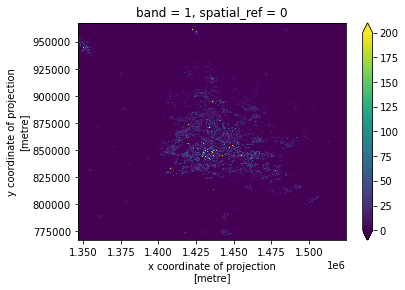

In [8]:
pop_proj.plot(vmin=0, vmax=200)

In [9]:
arr = pop_proj.values
affine = pop_proj.rio.transform()

In [10]:
%%time 
stats = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
)

/opt/conda/lib/python3.8/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


CPU times: user 28min 33s, sys: 1min 4s, total: 29min 37s
Wall time: 29min 37s


In [11]:
data['population'] = [x['mean'] for x in stats]

<AxesSubplot:>

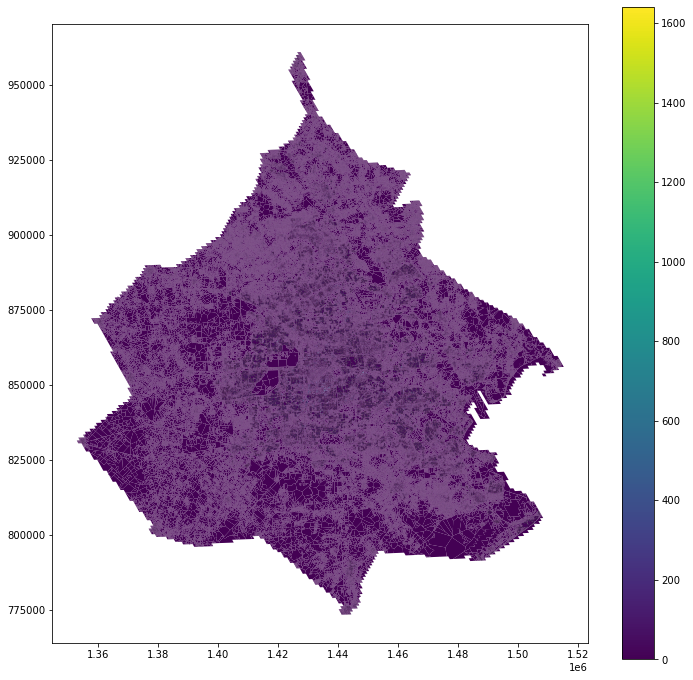

In [12]:
data.plot('population', figsize=(12, 12), legend=True, missing_kwds={"color": 'r'}, vmin=0)

In [14]:
data[['tID', 'population']].to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/population/population.pq")

### national land cover

In [13]:
download("https://s3-us-west-2.amazonaws.com/mrlc/NLCD_2016_Land_Cover_L48_20190424.zip",
         "../../urbangrammar_samba/sp_sig_concept/houston/land_cover", kind="zip")

Creating data folder...

file_sizes: 100%|██████████████████████████| 1.45G/1.45G [01:12<00:00, 20.1MB/s]
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/land_cover


'../../urbangrammar_samba/sp_sig_concept/houston/land_cover'

In [17]:
lc = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/houston/land_cover/NLCD_2016_Land_Cover_L48_20190424.img')

In [19]:
lc.crs

'+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True'

In [20]:
lc_clip = lc.rio.clip_box(*bounds.to_crs(lc.crs).total_bounds)
lc_proj = lc_clip.rio.reproject(data.crs)

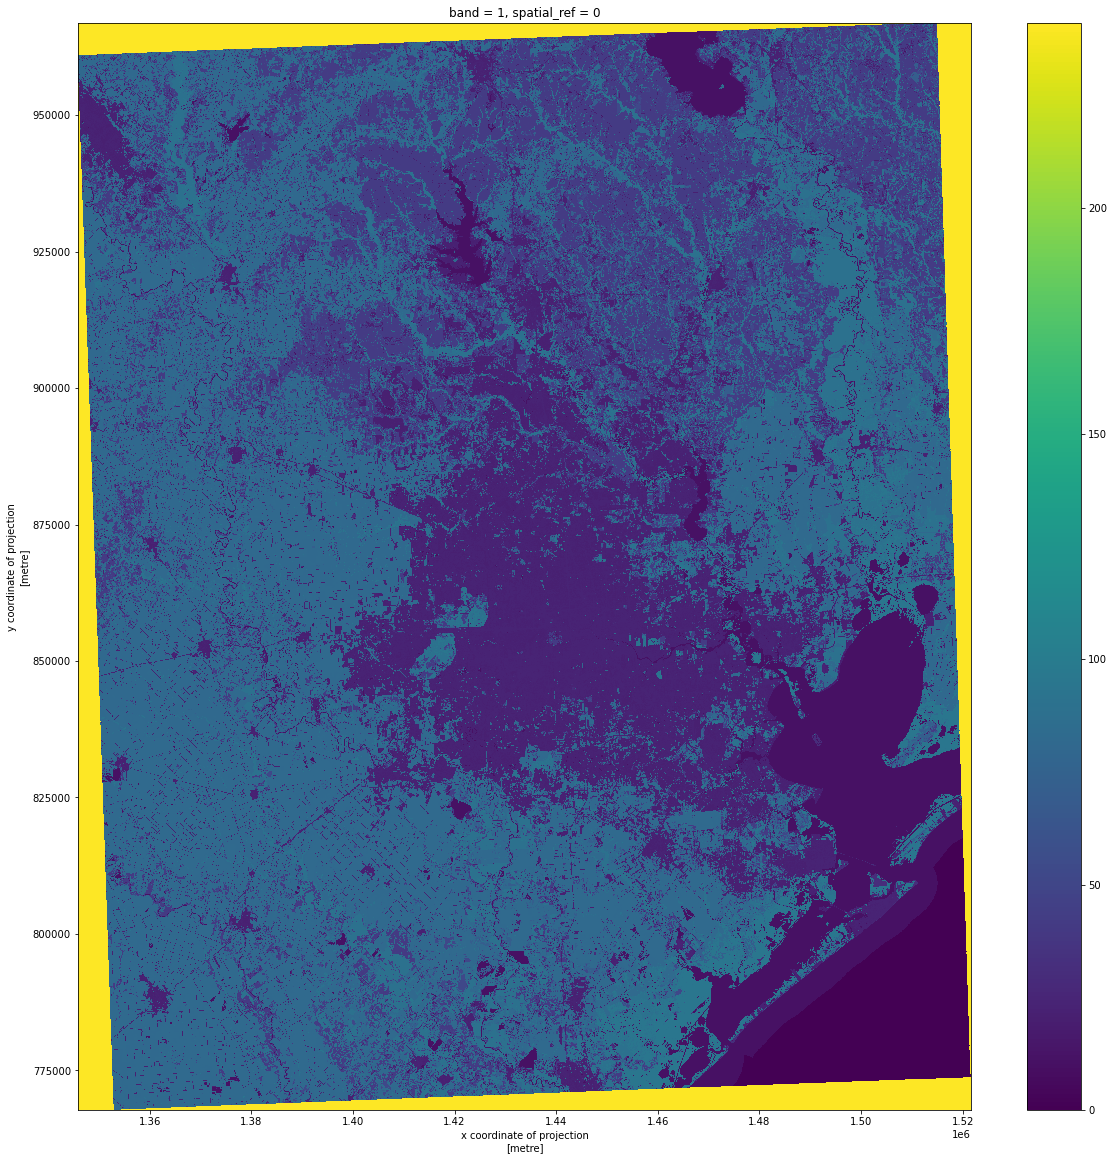

In [24]:
lc_proj.plot(figsize=(20, 20))

In [25]:
arr = lc_proj.values
affine = lc_proj.rio.transform()

In [26]:
%%time 
stats_lc = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['majority'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 30min 45s, sys: 1min 4s, total: 31min 50s
Wall time: 31min 50s


In [27]:
data['land_cover'] = [x['majority'] for x in stats_lc]

UnboundLocalError: local variable 'merged_kwds' referenced before assignment

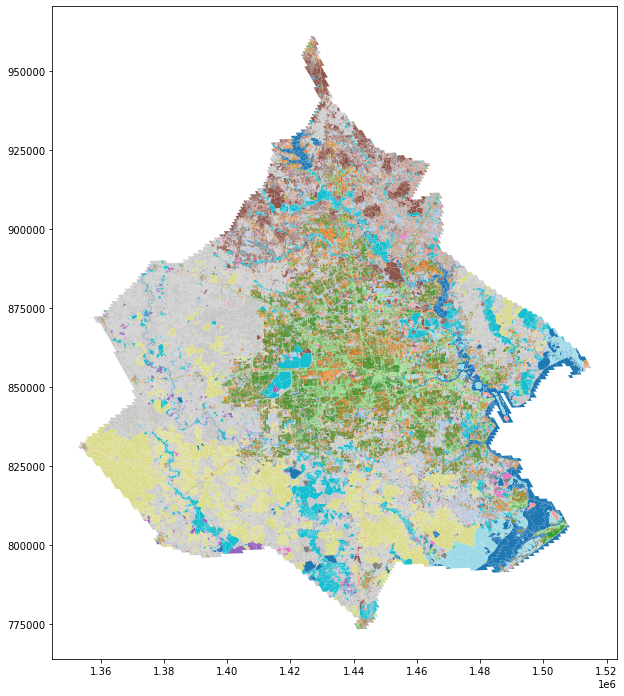

In [28]:
data.plot('land_cover', figsize=(12, 12), legend=True, missing_kwds={"color": 'r'}, categorical=True, cmap="tab20")

In [29]:
data[['tID', 'land_cover']].to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/land_cover/land_cover.pq")

### night lights

From https://eogdata.mines.edu/download_dnb_composites.html.

Requires login. Downloaded manually.

In [6]:
download("https://www.dropbox.com/s/u9hxtmxrcum2z5s/SVDNB_npp_20191101-20191130_75N180W_vcmcfg_v10_c201912131600.tgz?dl=1",
        "../../urbangrammar_samba/sp_sig_concept/houston/night_lights", kind="tar.gz")

Creating data folder...
Extracting tar.gz file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/night_lights


'../../urbangrammar_samba/sp_sig_concept/houston/night_lights'

In [7]:
nl = xarray.open_rasterio('../../urbangrammar_samba/sp_sig_concept/houston/night_lights/SVDNB_npp_20191101-20191130_75N180W_vcmcfg_v10_c201912131600.avg_rade9h.tif')

In [11]:
bounds = bounds.to_crs(nl.crs)

/opt/conda/lib/python3.8/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [12]:
nl_clip = nl.rio.clip_box(*bounds.total_bounds)
nl_proj = nl_clip.rio.reproject(data.crs)

In [13]:
arr = nl_proj.values
affine = nl_proj.rio.transform()

In [14]:
%%time 
stats_nl = rasterstats.zonal_stats(
    data.geometry, 
    raster=arr[0],
    affine=affine,
    stats=['mean'],
    all_touched=True,
    nodata = np.nan,
)

CPU times: user 29min 8s, sys: 1min 3s, total: 30min 11s
Wall time: 30min 12s


In [15]:
data['lights'] = [x['mean'] for x in stats_nl]

<AxesSubplot:>

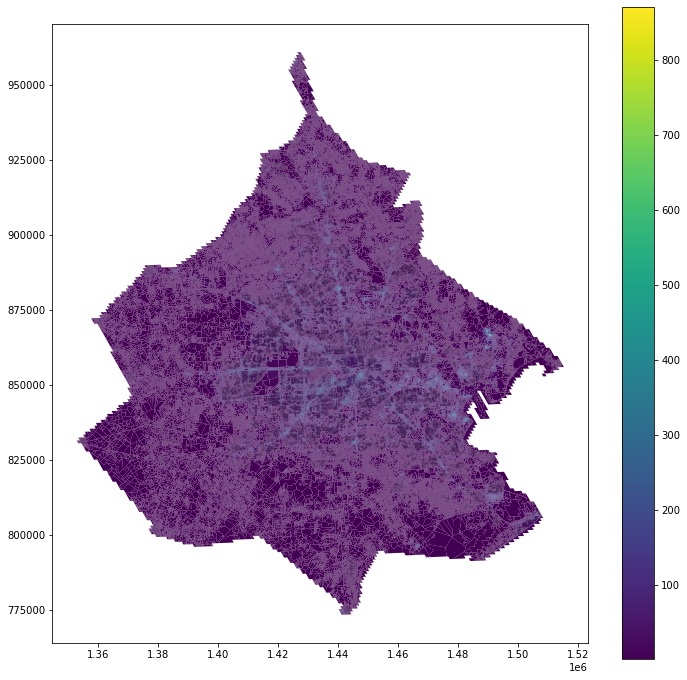

In [18]:
data.plot("lights", legend=True, figsize=(12, 12))

In [17]:
data[["lights", "tID"]].to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/night_lights/night_lights.pq")

### Workplace area characteristics
B08604

In [19]:
!pip install git+https://github.com/pysal/tobler.git

  Cloning https://github.com/pysal/tobler.git to /tmp/pip-req-build-p0ymodyk
  Created wheel for tobler: filename=tobler-0.5.4-py3-none-any.whl size=22766 sha256=f3df9b046bf4e072428353c64359b2b5b8d2047b6af95dfb07db55992576a68c
  Stored in directory: /tmp/pip-ephem-wheel-cache-_j5tftup/wheels/b5/03/ea/f439da068ed2904bc528f0d6a44cabae7dcfdebf806aa27aa3
Successfully built tobler
  Attempting uninstall: tobler
    Found existing installation: tobler 0.4.0
    Uninstalling tobler-0.4.0:
      Successfully uninstalled tobler-0.4.0


In [23]:
!pip install git+https://github.com/martinfleis/tobler.git@parallelfix

  Cloning https://github.com/martinfleis/tobler.git (to revision parallelfix) to /tmp/pip-req-build-l0i8sh_y
  Created wheel for tobler: filename=tobler-0.5.4-py3-none-any.whl size=22760 sha256=3a802a651303ecb178384011735a96ef16d20cf68252a348488388231da0fd74
  Stored in directory: /tmp/pip-ephem-wheel-cache-teuzlvd_/wheels/c9/e2/3a/e0af5b5fe3b5091e0b1228ef915da44043973c597beb7995d3
Successfully built tobler
Note: you may need to restart the kernel to use updated packages.


In [21]:
!pip install git+https://github.com/geopandas/geopandas.git

  Cloning https://github.com/geopandas/geopandas.git to /tmp/pip-req-build-u9kxwnxe
  Created wheel for geopandas: filename=geopandas-0.8.0+83.g1a6bb42-py2.py3-none-any.whl size=975845 sha256=6deaf0e4c33981e9abcd673f1c0c7c232eaf0baaa576896ce9912cb62310e6ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-i2isa0qe/wheels/f4/12/49/5364f812c3a52aa276f86fcd62d43de93344ab4ab2aef22a9d
Successfully built geopandas
  Attempting uninstall: geopandas
    Found existing installation: geopandas 0.8.0+82.gf53d77c
    Uninstalling geopandas-0.8.0+82.gf53d77c:
      Successfully uninstalled geopandas-0.8.0+82.gf53d77c


In [22]:
!pip install git+https://github.com/pygeos/pygeos.git

  Cloning https://github.com/pygeos/pygeos.git to /tmp/pip-req-build-jd8qai_y
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pygeos: filename=pygeos-0.8+43.g6493998-cp38-cp38-linux_x86_64.whl size=819670 sha256=4e579615bc041d967db940a038577b88ec14968eac82f4ad28ef62454bbf1f74
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ex84dxe/wheels/68/1e/8c/cabce66d98da4c8fdeb2c1b90833ea7bef0c4ef9d1cd38a43b
Successfully built pygeos
  Attempting uninstall: pygeos
    Found existing installation: pygeos 0.8
    Uninstalling pygeos-0.8:
      Successfully uninstalled pygeos-0.8


In [3]:
import tobler

In [52]:
download("https://www2.census.gov/geo/tiger/TIGER2010/TABBLOCK/2010/tl_2010_48_tabblock10.zip",
        "../../urbangrammar_samba/sp_sig_concept/houston/tiger_blocks", kind="zip")

Creating data folder...

file_sizes: 474MB [12:11, 648kB/s]                                              
Extracting zip file...
Successfully downloaded / unzipped to ../../urbangrammar_samba/sp_sig_concept/houston/tiger_blocks


'../../urbangrammar_samba/sp_sig_concept/houston/tiger_blocks'

In [4]:
geoms = gpd.read_file('../../urbangrammar_samba/sp_sig_concept/houston/tiger_blocks') 

In [5]:
geoms.GEOID10 = geoms.GEOID10.astype("int64")

In [6]:
wac = pd.read_csv("https://lehd.ces.census.gov/data/lodes/LODES7/tx/wac/tx_wac_S000_JT00_2018.csv.gz")

In [7]:
merged = geoms.merge(wac, left_on="GEOID10", right_on="w_geocode", how="left").fillna(0)

In [8]:
merged.shape

(914231, 69)

In [7]:
merged.columns

Index(['STATEFP10', 'COUNTYFP10', 'TRACTCE10', 'BLOCKCE10', 'GEOID10',
       'NAME10', 'MTFCC10', 'UR10', 'UACE10', 'UATYP10', 'FUNCSTAT10',
       'ALAND10', 'AWATER10', 'INTPTLAT10', 'INTPTLON10', 'geometry',
       'w_geocode', 'C000', 'CA01', 'CA02', 'CA03', 'CE01', 'CE02', 'CE03',
       'CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08',
       'CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15', 'CNS16',
       'CNS17', 'CNS18', 'CNS19', 'CNS20', 'CR01', 'CR02', 'CR03', 'CR04',
       'CR05', 'CR07', 'CT01', 'CT02', 'CD01', 'CD02', 'CD03', 'CD04', 'CS01',
       'CS02', 'CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05', 'CFS01', 'CFS02',
       'CFS03', 'CFS04', 'CFS05', 'createdate'],
      dtype='object')

In [9]:
jobs = ['CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05', 'CNS06', 'CNS07', 'CNS08',
       'CNS09', 'CNS10', 'CNS11', 'CNS12', 'CNS13', 'CNS14', 'CNS15', 'CNS16',
       'CNS17', 'CNS18', 'CNS19', 'CNS20']

In [10]:
merged = merged.to_crs(data.crs)

In [16]:
%time est = tobler.area_weighted.area_interpolate(merged, data, jobs, n_jobs=1)

CPU times: user 7min 21s, sys: 2.67 s, total: 7min 24s
Wall time: 7min 24s


In [ ]:
%time est = tobler.area_weighted.area_interpolate(merged, data, jobs, n_jobs=-1)

In [19]:
est['tID'] = data['tID'].values

In [20]:
est.drop(columns="geometry").to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/workplace.pq")

<ipython-input-20-c64476797e50>:1: UserWarning: this is an initial implementation of Parquet/Feather file support and associated metadata.  This is tracking version 0.1.0 of the metadata specification at https://github.com/geopandas/geo-arrow-spec

This metadata specification does not yet make stability promises.  We do not yet recommend using this in a production setting unless you are able to rewrite your Parquet/Feather files.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', message='.*initial implementation of Parquet.*')
  est.drop(columns="geometry").to_parquet("../../urbangrammar_samba/sp_sig_concept/houston/workplace.pq")


In [21]:
est.shape

(2043581, 22)

In [22]:
merged.shape

(914231, 69)